In [1]:
# numerical gradient
import numpy as np
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # back to original
        it.iternext()   
        
    return grad


# functions

def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # for not overflow
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # training data is one-hot-vector
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [2]:
#layers

import numpy as np

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx
    
class Affine:
    def __init__(self, W):
        self.W =W
#         self.b = b
        
        self.x = None
        self.original_x_shape = None
        self.dW = None
#         self.db = None

    def forward(self, x):
        # tensor
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

#         out = np.dot(self.x, self.W) + self.b
        out = np.dot(self.x, self.W)

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        
        dx = dx.reshape(*self.original_x_shape)  # back to reshape to inputdata
        return dx
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # output of softmax
        self.t = None # training data

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # training is one-hot-vector
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

In [3]:
# network 

import sys, os
sys.path.append(os.pardir)
import numpy as np
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # initalize params
        self.params = {}
        self.params['W1'] = weight_init_std * np.zeros((input_size, hidden_size))
        self.params['W2'] = weight_init_std * np.zeros((hidden_size, output_size))

        # layer creation
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'])
        self.layers['Sigmoid'] = Sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x:input data, t:training data
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x:input data, t:training data
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # grad
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW 
        grads['W2'] = self.layers['Affine2'].dW

        return grads


In [4]:
import sys, os
import numpy as np
from mnist import load_mnist

# data
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 3000
train_size = x_train.shape[0]
batch_size = 600
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []
test_acc_list_full = []

iter_per_epoch = max(train_size / batch_size, 1) # 100

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # grad
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # data revision
    for key in ('W1', 'W2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)

    
    if i % iter_per_epoch == 0:
        train_loss_list.append(loss)    
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        test_acc_list_full.append(1-test_acc)
    if i % iter_per_epoch == 0:
        print("test error: {}, learning curve (loss): {}".format(1-test_acc, loss))


test error: 0.8968, learning curve (loss): 2.3005401108538686
test error: 0.8865, learning curve (loss): 2.3000345803339184
test error: 0.8865, learning curve (loss): 2.3027036756477757
test error: 0.8865, learning curve (loss): 2.300818255087367
test error: 0.8865, learning curve (loss): 2.299751189269184
test error: 0.8865, learning curve (loss): 2.3083468795281243
test error: 0.8865, learning curve (loss): 2.3019852263221243
test error: 0.8865, learning curve (loss): 2.282594283151482
test error: 0.8865, learning curve (loss): 2.285499014905853
test error: 0.8865, learning curve (loss): 2.2919080806907473
test error: 0.8865, learning curve (loss): 2.2799640721250043
test error: 0.8865, learning curve (loss): 2.2562968206407548
test error: 0.8865, learning curve (loss): 2.22744966788767
test error: 0.8865, learning curve (loss): 2.206902394678791
test error: 0.8865, learning curve (loss): 2.162460252858513
test error: 0.8865, learning curve (loss): 2.205135703027754
test error: 0.886

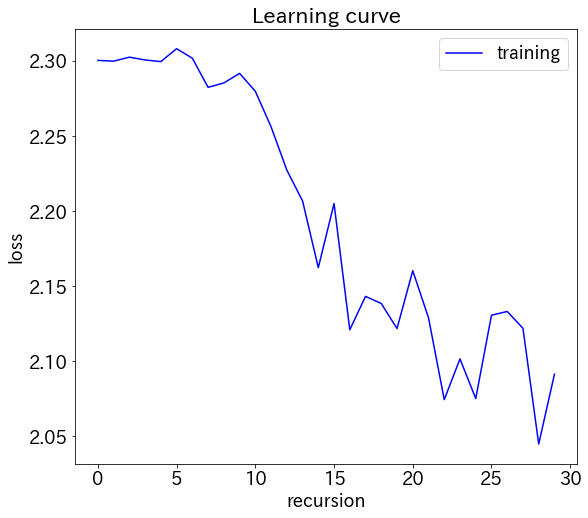

In [5]:
import matplotlib.pyplot as plt
import japanize_matplotlib
# Learning curve: loss

plt.rcParams['figure.figsize'] = (9,8)
plt.rcParams["font.size"] = 18
plt.plot(train_loss_list, 'b', label='training')
plt.xlabel('recursion')
plt.ylabel('loss')
plt.title('Learning curve')
plt.legend()
plt.show()

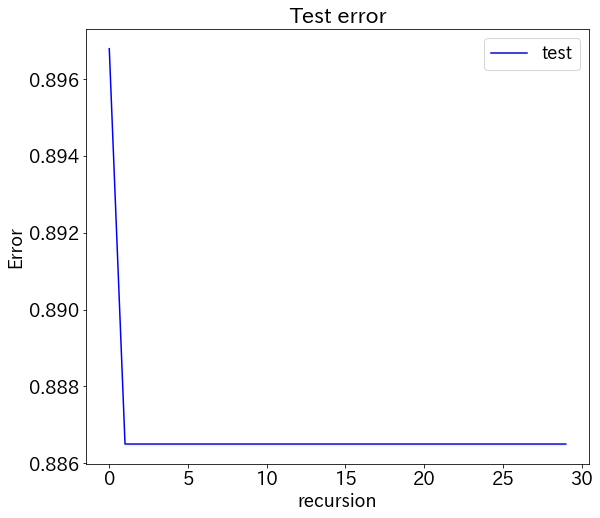

In [6]:
plt.rcParams['figure.figsize'] = (9,8)
plt.rcParams["font.size"] = 18
plt.plot(test_acc_list_full, 'b', label='test')
plt.xlabel('recursion')
plt.ylabel('Error')
plt.title('Test error')
plt.legend()
plt.show()
